## Lending Club Loan Data Analysis and Prediction - Part 3

Interesting Findings :
- Based on feature importance of the Random Forest model and Xgboost model,  loan grade/subgrade and issue year are the msot important features in separating good loans from bad loansm
- Other strong indicators of whether a loan will turn into default:
   * Verification status (not verified vs the rest of classes)
   * loan term
   * interest rate
   * debt-to-income ratio
   * home ownership status
   * accounts open for the past 24 months
   


### Project Outlines:

#### 1. Define goal 

    a.Identify most important attributes separating bad loans and good loans 
    b.Build Xgboost model to make prediction
    
#### 2. EDA

    a.Data first impression
      -available predicting variables
      -data distribution
      -missing values
    b.Split dataset in to training and test set
    c.correlation analysis and remove multicollinearity
    d.Data Visualization to explore relationship between target and predicting variables
    
#### 3. Data Cleansing and Feature Engineering

    a. Handling missing values
    b. Transform any characteristics or categorical variables into numeric
    c. Create new features from existing features

#### 4. Prepare dataset for modeling:
    - Standard scale
    - Handling Dataset imbalance issues 
        * upsampling the minority group
        * downsampling the majority group
        
#### 5. Model Training and Evaluation
    1). Logistic regression 
    2). Random Forest model 
    3). Xgboost model
        -hyperparameters Tuning
    
#### 6. Feature Selections Consideration
    - Remove variables according to correlation analysis
    - Logistic regression with L1 regularization (coeffecients not zero)
    - Random Forest model built-in feature importance

#### 7. Assess any additional feature engineering or feature selection opportunity based on model results

#### 8. Choose the best model and evaluate prediction on test dataset

#### 9. Areas of improvements


### Part-3
The project is split into 3 notebooks. The notebook is part three, focusing on model buiding and evaluation.


### Data Source
Link: https://www.kaggle.com/wordsforthewise/lending-club

 

In [140]:
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
matplotlib.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina' 
%matplotlib inline
from sklearn.linear_model import RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# load train, test set created from part1
xtrain = pd.read_csv("xtrain_cleaned.csv")
xtest = pd.read_csv("xtest_cleaned.csv")
ytrain = pd.read_csv("ytrain.csv", header= None)
ytest = pd.read_csv("ytest.csv", header= None)

In [3]:
# Remove the extra index column
ytrain = ytrain[1]
ytest = ytest[1]
xtrain = xtrain.drop("Unnamed: 0",axis = 1)
xtest = xtest.drop("Unnamed: 0",axis = 1 )

In [4]:
xtrain.head(5)

,loan_amnt,funded_amnt,int_rate,installment,grade,sub_grade,emp_length,annual_inc,zip_code,addr_state,...,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_verified_unknown,disbursement_method_Cash,disbursement_method_DirectPay,is_null_total_cu_tl,is_null_tot_cur_bal
0,35000.0,35000.0,9.93,1128.21,9.0,8.0,2,85000.0,8.99,9.75,...,0,1,0,1,0,0,1,0,0,0
1,10000.0,10000.0,10.16,323.43,9.0,7.0,8,133000.0,12.89,14.85,...,0,1,1,0,0,0,1,0,0,0
2,10000.0,10000.0,18.92,258.97,21.0,23.0,10,62000.0,14.58,14.85,...,0,1,0,1,0,0,1,0,0,0
3,35000.0,35000.0,7.39,1086.96,4.0,4.0,5,150000.0,13.05,13.77,...,0,1,0,0,1,0,1,0,0,0
4,4200.0,4200.0,7.89,131.40,4.0,6.0,1,27000.0,12.27,12.53,...,0,1,1,0,0,0,1,0,0,0


### Prepare data for modeling

#### Assess features' skewness, perform logarithm transformation and normalization

In [5]:
# collect all columns
all_cols = xtrain.columns.tolist()

# compute skewness for all columns
skew_dict= dict()
skew_dict["columns"]=[]
skew_dict["skewness"]=[]
for col in all_cols:
    skew_dict["columns"].append(col)
    skew_dict["skewness"].append(xtrain[col].skew())

skew_df = pd.DataFrame(skew_dict)   


In [6]:
skew_df

,columns,skewness
0,loan_amnt,0.777848
1,funded_amnt,0.778844
2,int_rate,0.769178
3,installment,1.002112
4,grade,0.991339
...,...,...
138,verification_status_verified_unknown,21.297609
139,disbursement_method_Cash,-5.093727
140,disbursement_method_DirectPay,5.093727
141,is_null_total_cu_tl,0.000000


In [7]:
# Select features whose skewness is greater than 1 and to use datetype select non-dummy features
skew_list = skew_df.loc[skew_df.skewness > 1, "columns"].values.tolist()
skew_dtype = pd.DataFrame({"skewed columns":skew_list, "dtype": [xtrain[col].dtype for col in skew_list]})
to_tran = skew_dtype.loc[skew_dtype.dtype=="float64", "skewed columns"].tolist()


####  Standard-scale 

In [13]:
# Create the Scaler object
scaler = StandardScaler()
# Fit log_transformed data on the scaler object
sca_xtrain = scaler.fit_transform(xtrain)
sca_xtrain = pd.DataFrame(sca_xtrain, columns=all_cols)

In [159]:
# Apply the scaler to transform the test set
sca_xtest = scaler.transform(xtest)

In [163]:
# add back column names
sca_xtest = pd.DataFrame(sca_xtest, columns=all_cols)

#### Create train and validation set

In [14]:
# Create training set and validation set
x_tr, x_val, y_tr, y_val = train_test_split(sca_xtrain, ytrain, test_size=0.2, random_state=1, stratify=ytrain)


In [15]:
x_tr.head(5)

,loan_amnt,funded_amnt,int_rate,installment,grade,sub_grade,emp_length,annual_inc,zip_code,addr_state,...,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_verified_unknown,disbursement_method_Cash,disbursement_method_DirectPay,is_null_total_cu_tl,is_null_tot_cur_bal
965259,-1.092844,-1.092493,1.429214,-0.972724,0.978536,1.177874,1.140589,0.971420,-1.224975,-1.377166,...,-0.354852,-0.809653,-0.709543,-0.803894,1.642673,-0.046851,0.189286,-0.189286,0.0,-0.179525
841305,0.321597,0.322231,-1.159541,0.426887,-1.204616,-1.171439,1.140589,0.037490,-0.846824,-0.484098,...,-0.354852,1.235097,1.409359,-0.803894,-0.608764,-0.046851,0.189286,-0.189286,0.0,-0.179525
1049646,-0.331222,-0.330719,2.430778,0.113592,2.005901,1.919763,1.140589,-0.290204,-0.175740,-0.811557,...,-0.354852,-0.809653,-0.709543,1.243945,-0.608764,-0.046851,0.189286,-0.189286,0.0,-0.179525
859101,0.648007,0.648706,1.729269,0.477856,0.978536,1.301522,1.140589,-0.167319,0.298280,-0.208736,...,-0.354852,-0.809653,-0.709543,1.243945,-0.608764,-0.046851,0.189286,-0.189286,0.0,-0.179525
1467468,-1.092844,-1.092493,-0.451824,-1.056287,-0.562512,-0.429551,-0.508743,-0.380320,0.388823,-0.111987,...,-0.354852,1.235097,-0.709543,1.243945,-0.608764,-0.046851,0.189286,-0.189286,0.0,-0.179525


### Fit Models
#### Base model : Logistic Regression

In [37]:
# Train Logistic Regression
logreg = LogisticRegression(random_state = 0)
logreg.fit(x_tr, y_tr)

LogisticRegression(random_state=0)

In [38]:
# Run prediction with the validation dataset
logreg_yp = logreg.predict(x_val)

#Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.
logreg_yproba = logreg.predict_proba(x_val)[:,1]

In [39]:
# Make confusion matrix
logreg_matrix = metrics.confusion_matrix(y_val, logreg_yp )
logreg_matrix

array([[311162,   1967],
       [ 46559,   2019]])

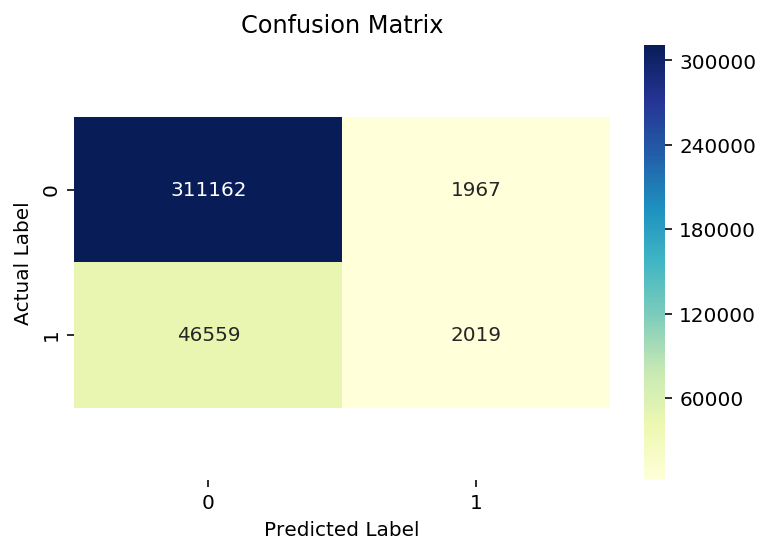

In [40]:
%matplotlib inline

sns.heatmap(logreg_matrix,annot=True,cmap="YlGnBu" ,fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

class_names=[0,1] # name  of classes
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs,class_names)
ylocs, ylabels = plt.xticks()
plt.yticks(ylocs,class_names)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()


Althought the ROC-AUC score of prediction on the validation set using first logsitic regression model looks good (about 73%), the recall score of class 1 is 4% while 99% for class 0, which means that the model is really poor at identifying bad-condition loans. When there is a significant difference in recall score between classes, most likely it is due to dataset imbalance (class 1 accounts for only 13%).

In [41]:
# Calculate the classification report.

print(classification_report(y_val, logreg_yp))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93    313129
           1       0.51      0.04      0.08     48578

    accuracy                           0.87    361707
   macro avg       0.69      0.52      0.50    361707
weighted avg       0.82      0.87      0.81    361707



In [42]:
#d) Calculate the AUC score 
print(roc_auc_score(y_val,logreg_yproba ))

0.7367624917290755


In [43]:
print("Accuracy:", round(metrics.accuracy_score(y_val, logreg_yp),4))
print("Precision:",round(metrics.precision_score(y_val, logreg_yp),4))
print("Recall/TPR:",round(metrics.recall_score(y_val, logreg_yp),4))

Accuracy: 0.8658
Precision: 0.5065
Recall/TPR: 0.0416


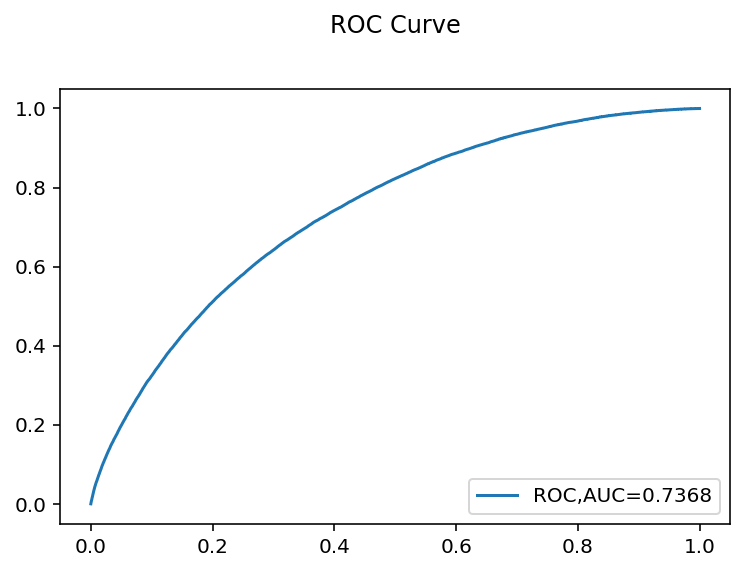

In [44]:
# Graph Receiver Operating Characteristic(ROC) curve and compute AUC (Area Under the Receiver Operating Characteristic Curve) from prediction scores.
fpr, tpr, _ = metrics.roc_curve(y_val,  logreg_yproba)
auc = metrics.roc_auc_score(y_val, logreg_yproba)
plt.plot(fpr,tpr,label="ROC,AUC="+str(round(auc,4)))
plt.title('ROC Curve', y=1.1)
plt.legend(loc=4)
plt.show()

#### Logistic Regression with Regularization (elasticnet)

In [45]:
log_l2_model = LogisticRegression(penalty ="l2", random_state = 0, solver ="saga")
log_l2_model.fit(x_tr, y_tr)

LogisticRegression(random_state=0, solver='saga')

In [46]:
with open('log_l2_model.pickle', 'wb') as f:
    pickle.dump(log_l2_model, f)

In [47]:
# with open('log_l2_model.pickle', 'rb') as f:
#     log_l2_model = pickle.load(f)

In [48]:
# thetaLasso=log_l2_model.coef_[0]
# cols_lasso = thetaLasso.round(0) != 0
# cols_lasso = cols_lasso.tolist()

# # Select features with Logistic regression with L1 penalty
# filtered_list = x_tr.columns[cols_lasso].tolist()
# filtered_list

In [49]:
# Run prediction with the validation dataset
log_l2_pred = log_l2_model.predict(x_val)

In [50]:
# Make confusion matrix
log_l2_matrix = metrics.confusion_matrix(y_val, log_l2_pred)
log_l2_matrix

array([[311326,   1803],
       [ 46710,   1868]])

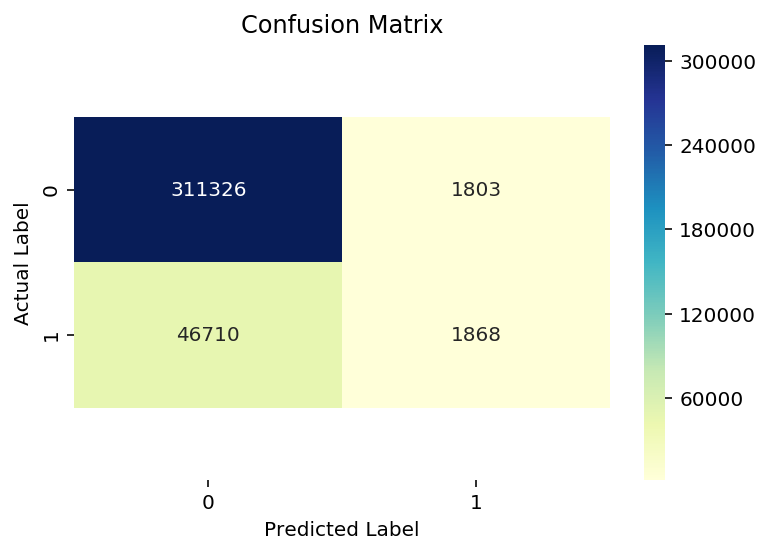

In [51]:
%matplotlib inline

sns.heatmap(log_l2_matrix,annot=True,cmap="YlGnBu" ,fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

class_names=[0,1] # name  of classes
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs,class_names)
ylocs, ylabels = plt.xticks()
plt.yticks(ylocs,class_names)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()


In [52]:
# Calculate the classification report.

print(classification_report(y_val, log_l2_pred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93    313129
           1       0.51      0.04      0.07     48578

    accuracy                           0.87    361707
   macro avg       0.69      0.52      0.50    361707
weighted avg       0.82      0.87      0.81    361707



In [53]:
print("Accuracy:", round(metrics.accuracy_score(y_val, log_l2_pred),4))
print("Precision:",round(metrics.precision_score(y_val, log_l2_pred),4))
print("Recall/TPR:",round(metrics.recall_score(y_val, log_l2_pred),4))

Accuracy: 0.8659
Precision: 0.5089
Recall/TPR: 0.0385


In [54]:
# Get the probability score for observations.
log_l2_proba = log_l2_model.predict_proba(x_val)[::,1]

# Calculate the AUC score 
print(roc_auc_score(y_val,log_l2_proba))

0.7358494084254235


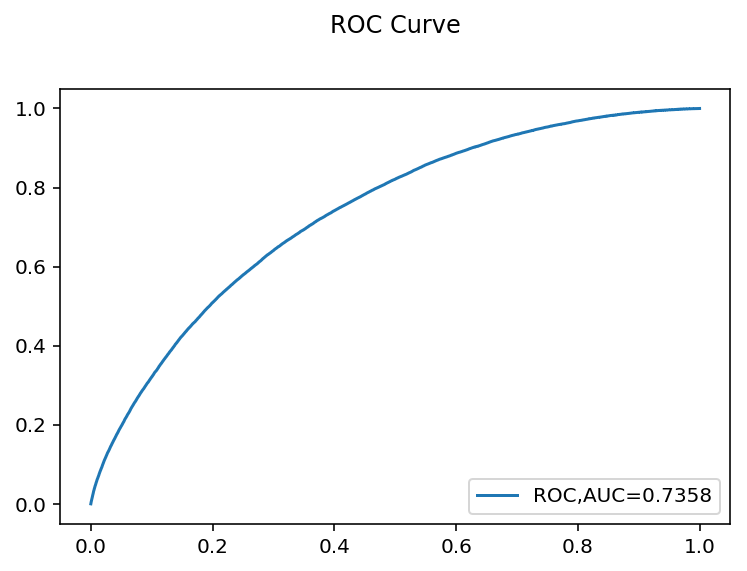

In [55]:
# Graph Receiver Operating Characteristic(ROC) curve and compute AUC (Area Under the Receiver Operating Characteristic Curve) from prediction scores.
fpr, tpr, _ = metrics.roc_curve(y_val,  log_l2_proba)
auc = metrics.roc_auc_score(y_val, log_l2_proba)
plt.plot(fpr,tpr,label="ROC,AUC="+str(round(auc,4)))
plt.title('ROC Curve', y=1.1)
plt.legend(loc=4)
plt.show()

Again, we noted that the Recall scores on the second model were pretty low, at 0.04, which means that it can only correctly identify 4% of the bad loans out of all the bad loans in the data set. The first two models didn't perform very well in predicting on the validation set. Let's start with handling the dataset imbalance issue.

### Handle imbalanced dataset

Here I am using the following two methods:

- Upsampling minority group with RandomOverSampler 
- Downsampling majority group with RandomUnderSampler

In [56]:
# Random over-samples the minority group to handle the imbalanced dataset
ros = RandomOverSampler(sampling_strategy =0.5,random_state=42)
x_res, y_res = ros.fit_resample(x_tr, y_tr)

In [57]:
# Check out the ratio of bad loans vs good loans in our resampled dataset
sum(y_res==1)/len(y_res)

0.33333315591247903

### Logistic Regression with Balanced Training Data (random oversampling)

In [58]:
logreg_2 = LogisticRegression(random_state = 0)
logreg_2.fit(x_res, y_res)

LogisticRegression(random_state=0)

In [59]:
# Run prediction with the validation dataset
logreg_2_yp = logreg_2.predict(x_val)

#Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.
logreg_2_yproba = logreg_2.predict_proba(x_val)[:,1]

In [60]:
# Make confusion matrix
logreg_2_matrix = metrics.confusion_matrix(y_val, logreg_2_yp )
logreg_2_matrix

array([[278350,  34779],
       [ 31724,  16854]])

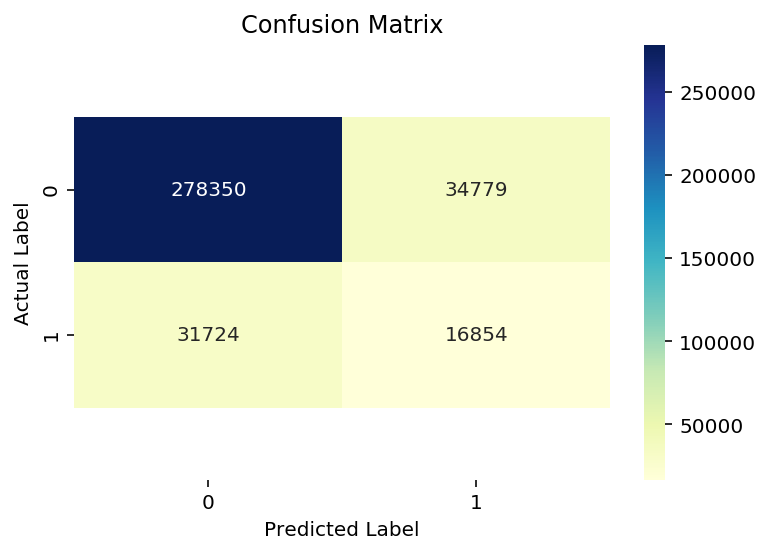

In [61]:
%matplotlib inline

sns.heatmap(logreg_2_matrix,annot=True,cmap="YlGnBu" ,fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

class_names=[0,1] # name  of classes
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs,class_names)
ylocs, ylabels = plt.xticks()
plt.yticks(ylocs,class_names)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()


The recall score of class 1 is improved to 0.35

In [62]:
# Calculate the classification report.

print(classification_report(y_val, logreg_2_yp))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89    313129
           1       0.33      0.35      0.34     48578

    accuracy                           0.82    361707
   macro avg       0.61      0.62      0.61    361707
weighted avg       0.82      0.82      0.82    361707



In [63]:
#d) Calculate the AUC score 
print(roc_auc_score(y_val,logreg_2_yproba ))

0.7371847760464445


In [64]:
print("Accuracy:", round(metrics.accuracy_score(y_val, logreg_2_yp),4))
print("Precision:",round(metrics.precision_score(y_val, logreg_2_yp),4))
print("Recall/TPR:",round(metrics.recall_score(y_val, logreg_2_yp),4))

Accuracy: 0.8161
Precision: 0.3264
Recall/TPR: 0.3469


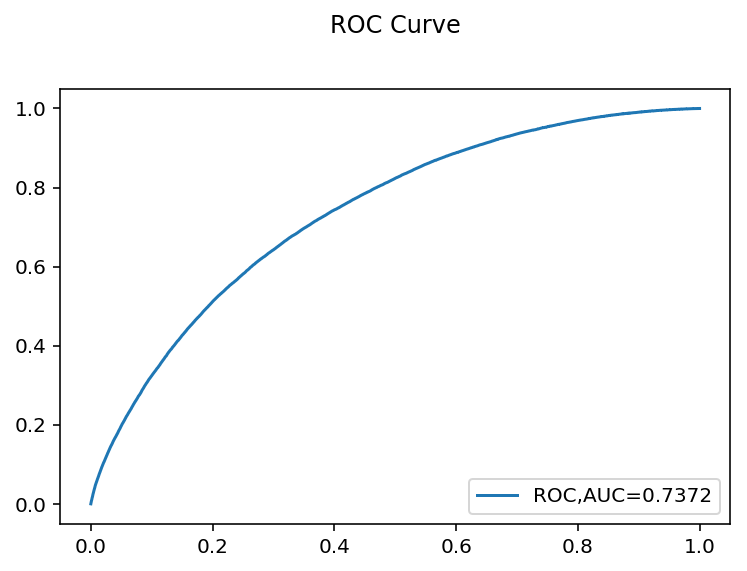

In [65]:
# Graph Receiver Operating Characteristic(ROC) curve and compute AUC (Area Under the Receiver Operating Characteristic Curve) from prediction scores.
fpr, tpr, _ = metrics.roc_curve(y_val,  logreg_2_yproba)
auc = metrics.roc_auc_score(y_val, logreg_2_yproba)
plt.plot(fpr,tpr,label="ROC,AUC="+str(round(auc,4)))
plt.title('ROC Curve', y=1.1)
plt.legend(loc=4)
plt.show()

### Handle imbalanced dataset by Upsampling 

In [67]:
# Random under-samples the majority group to handle the imbalanced dataset
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
# fit and apply the transform
x_rus, y_rus = rus.fit_resample(x_tr, y_tr)

In [66]:
# #Another oversampling method is SMOTE method, upsampling by generating synthetic data
# sm = SMOTENC(random_state=42, sampling_strategy =0.5) 
# x_sa, y_sa = sm.fit_resample(x_tr, y_tr)

In [68]:
# Check out the ratio of bad loans vs good loans in our resampled dataset
sum(y_rus==1)/len(y_rus)

0.3333333333333333

In [70]:
x_rus.shape

(582936, 143)

### Logistic Regression with Balanced Training Data (random oversampling)

In [71]:
logreg_3 = LogisticRegression(random_state = 0)
logreg_3.fit(x_rus, y_rus)

LogisticRegression(random_state=0)

In [80]:
# Run prediction with the training dataset
logreg_3_yp_rus = logreg_3.predict(x_rus)


In [81]:
# Calculate the classification report for prediction on training set

print(classification_report(y_rus, logreg_3_yp_rus))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80    388624
           1       0.61      0.34      0.44    194312

    accuracy                           0.71    582936
   macro avg       0.67      0.62      0.62    582936
weighted avg       0.69      0.71      0.68    582936



In [72]:
# Run prediction with the validation dataset
logreg_3_yp = logreg_3.predict(x_val)

#Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.
logreg_3_yproba = logreg_3.predict_proba(x_val)[:,1]

In [83]:
# Calculate the classification report for prediction on validation set

print(classification_report(y_val, logreg_3_yp))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89    313129
           1       0.33      0.35      0.34     48578

    accuracy                           0.82    361707
   macro avg       0.61      0.62      0.61    361707
weighted avg       0.82      0.82      0.82    361707



In [73]:
# Make confusion matrix
logreg_3_matrix = metrics.confusion_matrix(y_val, logreg_3_yp )
logreg_3_matrix

array([[278417,  34712],
       [ 31732,  16846]])

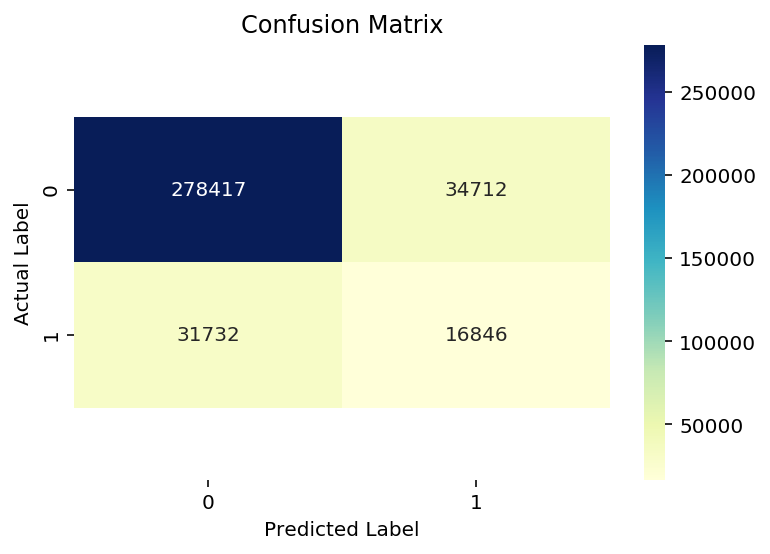

In [74]:
%matplotlib inline

sns.heatmap(logreg_3_matrix,annot=True,cmap="YlGnBu" ,fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

class_names=[0,1] # name  of classes
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs,class_names)
ylocs, ylabels = plt.xticks()
plt.yticks(ylocs,class_names)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()


The recall score of class 1 is improved to 0.35

In [76]:
#d) Calculate the AUC score 
print(roc_auc_score(y_val,logreg_3_yproba ))

0.7371610596755469


In [77]:
print("Accuracy:", round(metrics.accuracy_score(y_val, logreg_3_yp),4))
print("Precision:",round(metrics.precision_score(y_val, logreg_3_yp),4))
print("Recall/TPR:",round(metrics.recall_score(y_val, logreg_3_yp),4))

Accuracy: 0.8163
Precision: 0.3267
Recall/TPR: 0.3468


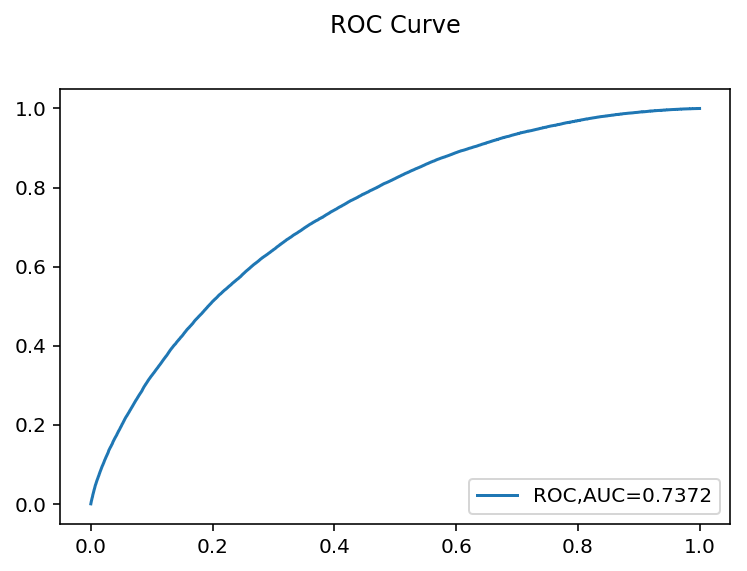

In [78]:
# Graph Receiver Operating Characteristic(ROC) curve and compute AUC (Area Under the Receiver Operating Characteristic Curve) from prediction scores.
fpr, tpr, _ = metrics.roc_curve(y_val,  logreg_3_yproba)
auc = metrics.roc_auc_score(y_val, logreg_3_yproba)
plt.plot(fpr,tpr,label="ROC,AUC="+str(round(auc,4)))
plt.title('ROC Curve', y=1.1)
plt.legend(loc=4)
plt.show()

### Handle imbalanced dataset

Here I am using the following two methods:

- Upsampling minority group with RandomOverSampler 
- Downsampling majority group with RandomUnderSampler

In [189]:
# Random over-samples the minority group to be the same sample size as the majority group
ros_2 = RandomOverSampler(sampling_strategy =1,random_state=42)
x_res_2, y_res_2 = ros_2.fit_resample(x_tr, y_tr)

In [190]:
# Check out the ratio of bad loans vs good loans in our resampled dataset
sum(y_res_2==1)/len(y_res_2)

0.5

### Logistic Regression with Balanced Training Data (random oversampling)

In [191]:
logreg_4 = LogisticRegression(random_state = 0)
logreg_4.fit(x_res_2, y_res_2)

LogisticRegression(random_state=0)

In [192]:
# Run prediction with the validation dataset
logreg_4_yp = logreg_4.predict(x_val)

#Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.
logreg_4_yproba = logreg_4.predict_proba(x_val)[:,1]

In [193]:
# Make confusion matrix
logreg_4_matrix = metrics.confusion_matrix(y_val, logreg_4_yp )
logreg_4_matrix

array([[211161, 101968],
       [ 15943,  32635]])

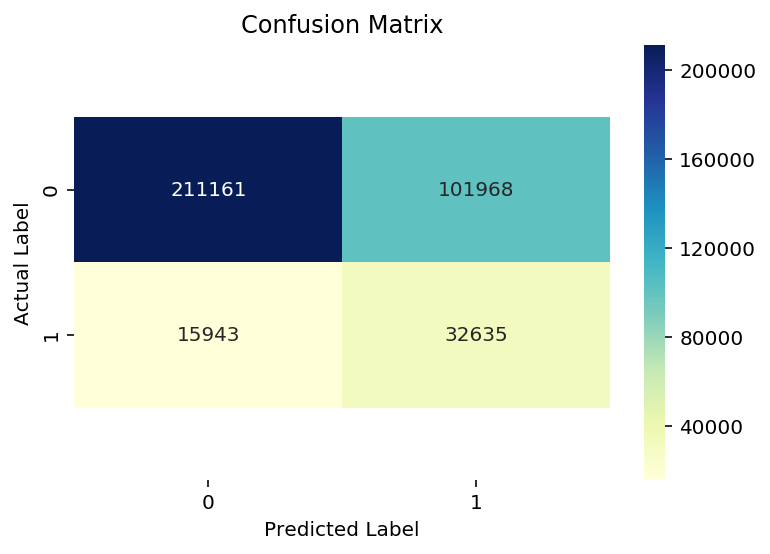

In [194]:
%matplotlib inline

sns.heatmap(logreg_4_matrix,annot=True,cmap="YlGnBu" ,fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

class_names=[0,1] # name  of classes
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs,class_names)
ylocs, ylabels = plt.xticks()
plt.yticks(ylocs,class_names)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()


The recall score of class 1 is improved to 0.67

In [195]:
# Calculate the classification report.

print(classification_report(y_val, logreg_4_yp))

              precision    recall  f1-score   support

           0       0.93      0.67      0.78    313129
           1       0.24      0.67      0.36     48578

    accuracy                           0.67    361707
   macro avg       0.59      0.67      0.57    361707
weighted avg       0.84      0.67      0.72    361707



In [196]:
#d) Calculate the AUC score 
print(roc_auc_score(y_val,logreg_4_yproba ))

0.7373206685888789


In [197]:
print("Accuracy:", round(metrics.accuracy_score(y_val, logreg_4_yp),4))
print("Precision:",round(metrics.precision_score(y_val, logreg_4_yp),4))
print("Recall/TPR:",round(metrics.recall_score(y_val, logreg_4_yp),4))

Accuracy: 0.674
Precision: 0.2425
Recall/TPR: 0.6718


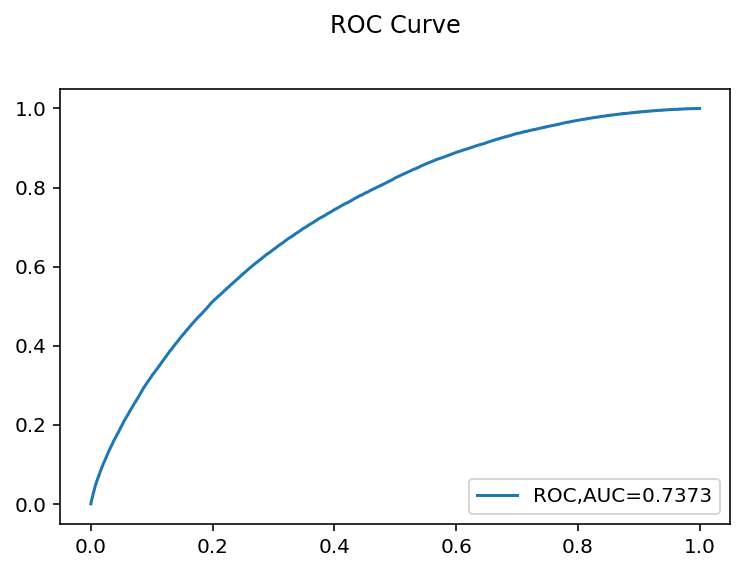

In [198]:
# Graph Receiver Operating Characteristic(ROC) curve and compute AUC (Area Under the Receiver Operating Characteristic Curve) from prediction scores.
fpr, tpr, _ = metrics.roc_curve(y_val,  logreg_4_yproba)
auc = metrics.roc_auc_score(y_val, logreg_4_yproba)
plt.plot(fpr,tpr,label="ROC,AUC="+str(round(auc,4)))
plt.title('ROC Curve', y=1.1)
plt.legend(loc=4)
plt.show()

### Random Forest Model
We can use the built-in variable importance in RF model for our feature selections. 

In [87]:
# Instantiate a RandomforestClassifier using default Gini method
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit dt to the training set
rf.fit(x_res, y_res)

RandomForestClassifier(random_state=42)

In [88]:
with open('rf_model.pickle', 'wb') as f:
    pickle.dump(rf, f)
# with open('rf_model.pickle', 'rb') as f:
#     rf = pickle.load(f)

In [89]:
# Run prediction with the validation dataset
rf_yp = rf.predict(x_val)

In [90]:
# Make confusion matrix
rf_matrix = metrics.confusion_matrix(y_val,rf_yp)
rf_matrix

array([[310379,   2750],
       [ 46171,   2407]])

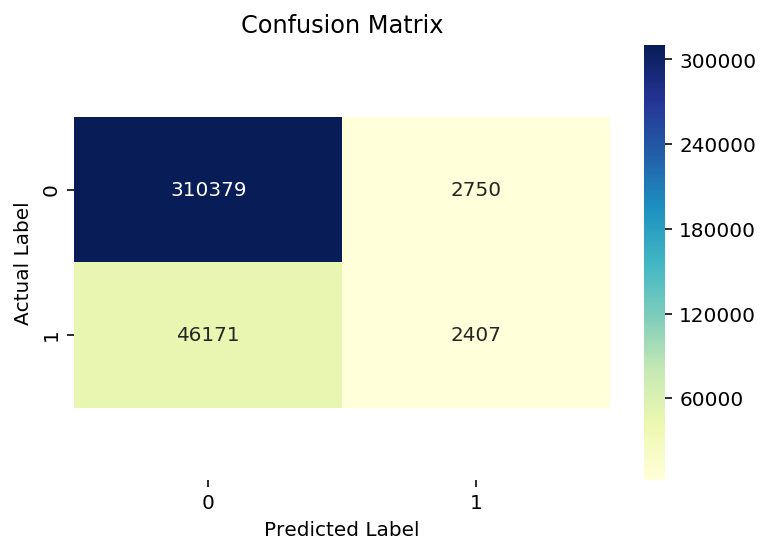

In [91]:
%matplotlib inline

sns.heatmap(rf_matrix,annot=True,cmap="YlGnBu" ,fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

class_names=[0,1] # name  of classes
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs,class_names)
ylocs, ylabels = plt.xticks()
plt.yticks(ylocs,class_names)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()


In [92]:
# Calculate the classification report.

print(classification_report(y_val, rf_yp))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93    313129
           1       0.47      0.05      0.09     48578

    accuracy                           0.86    361707
   macro avg       0.67      0.52      0.51    361707
weighted avg       0.82      0.86      0.81    361707



In [93]:
print("Accuracy:", round(metrics.accuracy_score(y_val, rf_yp),4))
print("Precision:",round(metrics.precision_score(y_val, rf_yp),4))
print("Recall/TPR:",round(metrics.recall_score(y_val, rf_yp),4))

Accuracy: 0.8647
Precision: 0.4667
Recall/TPR: 0.0495


In [94]:
# Get the probability score for observations.
rf_yproba = rf.predict_proba(x_val)[::,1]

# Calculate the AUC score 
print(roc_auc_score(y_val,rf_yproba ))

0.7376975130406712


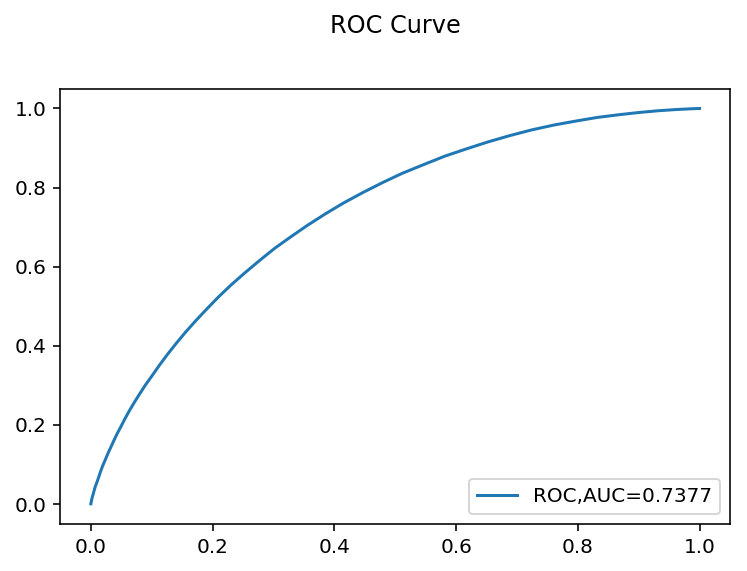

In [95]:
# Graph Receiver Operating Characteristic(ROC) curve and compute AUC (Area Under the Receiver Operating Characteristic Curve) from prediction scores.
fpr, tpr, _ = metrics.roc_curve(y_val,  rf_yproba)
auc = metrics.roc_auc_score(y_val, rf_yproba)
plt.plot(fpr,tpr,label="ROC,AUC="+str(round(auc,4)))
plt.title('ROC Curve', y=1.1)
plt.legend(loc=4)
plt.show()

In [96]:
# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_,
    index = x_tr.columns)

# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values(ascending=False)
sorted_importances_rf[:20]

sub_grade               0.034868
int_rate                0.032180
issue_year              0.027517
grade                   0.022321
dti                     0.022105
zip_code                0.021077
annual_inc              0.019951
installment             0.019890
revol_util              0.019030
bc_open_to_buy          0.018970
revol_bal               0.018789
avg_cur_bal             0.018491
tot_hi_cred_lim         0.018278
mo_sin_old_rev_tl_op    0.018079
total_bc_limit          0.018043
bc_util                 0.018036
tot_cur_bal             0.017574
mo_sin_old_il_acct      0.017362
total_rev_hi_lim        0.017303
total_bal_ex_mort       0.017084
dtype: float64

In [97]:
print("The first 20 features accounts for " + str(round(sum(sorted_importances_rf[:20]),4)*100)+"%")

The first 20 features accounts for 41.69%


In [98]:
rf_feat = sorted_importances_rf.index[:20].tolist()
print("Top 20 Features selected by random forest:")
print(rf_feat)

Top 20 Features selected by random forest:
['sub_grade', 'int_rate', 'issue_year', 'grade', 'dti', 'zip_code', 'annual_inc', 'installment', 'revol_util', 'bc_open_to_buy', 'revol_bal', 'avg_cur_bal', 'tot_hi_cred_lim', 'mo_sin_old_rev_tl_op', 'total_bc_limit', 'bc_util', 'tot_cur_bal', 'mo_sin_old_il_acct', 'total_rev_hi_lim', 'total_bal_ex_mort']


In [108]:
def plot_feature_importance(model, dataset):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(model.feature_importances_)
    feature_names = np.array(dataset.columns)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    fi_df_tp20 =fi_df[:20]
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df_tp20['feature_importance'], y=fi_df_tp20['feature_names'])
    #Add chart labels
    plt.title(type(model).__name__ + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

#### Plot feature importance

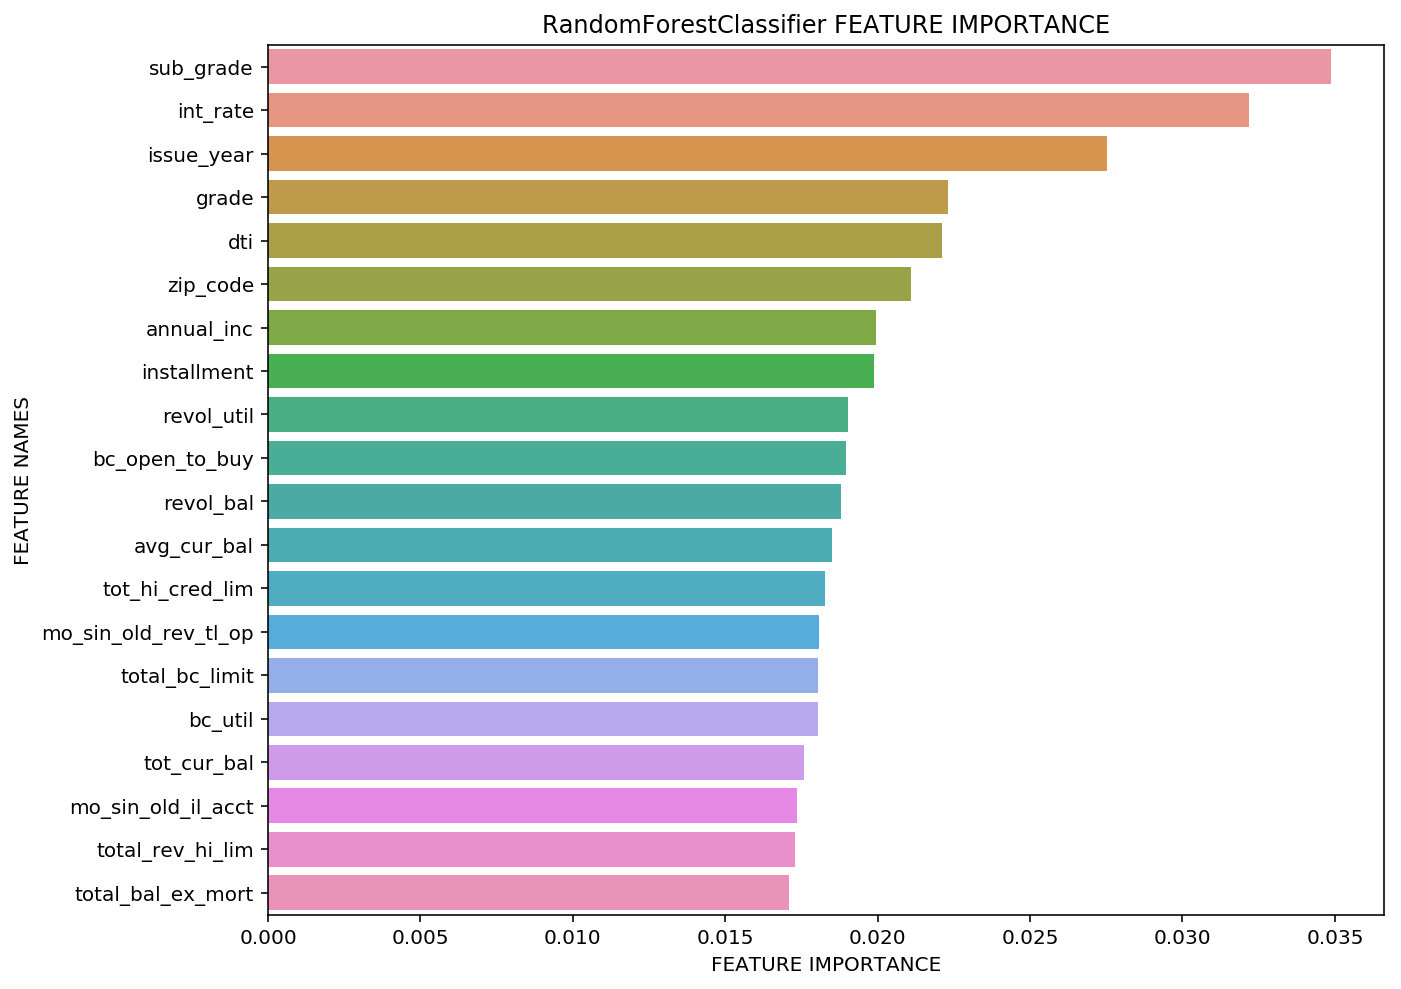

In [109]:
plot_feature_importance(rf, x_tr)

#### Xgboost model

In [112]:
#data_dmatrix = xgb.DMatrix(data=x_res ,label=y_res)

xgb1 = XGBClassifier(
                     learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                     scale_pos_weight=1,
                     eval_metric='auc',
                     seed=27)


In [113]:
# Fit the data into xgboost model-1
xgb1.fit(x_res, y_res)

XGBClassifier(colsample_bytree=0.8, eval_metric='auc', max_depth=5,
              n_estimators=1000, seed=27, subsample=0.8)

In [114]:
# Predict on the validation set
xg_y_pred = xgb1.predict(x_val)

In [115]:
with open('xgb1_model.pickle', 'wb') as f:
    pickle.dump(xgb1, f)
# with open('xgb1_model.pickle', 'rb') as f:
#     xgb1 = pickle.load(f)

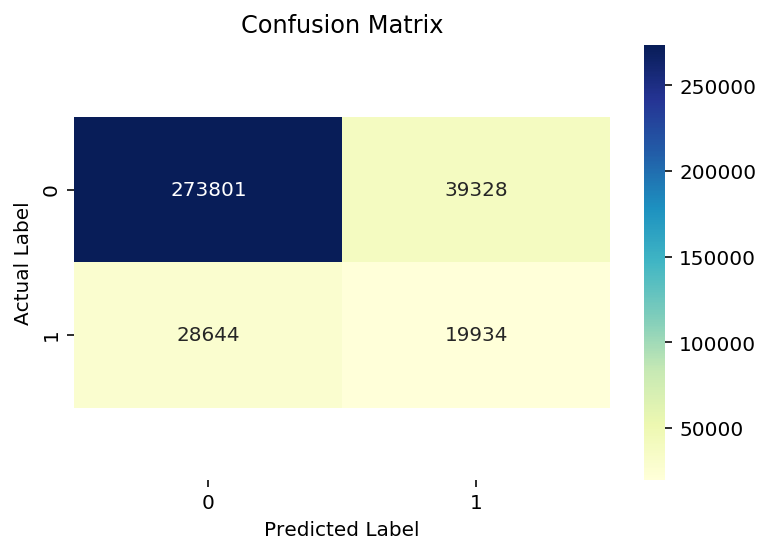

In [119]:
xgb1_matrix = metrics.confusion_matrix(y_val, xg_y_pred)


%matplotlib inline

sns.heatmap(xgb1_matrix,annot=True,cmap="YlGnBu" ,fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

class_names=[0,1] # name  of classes
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs,class_names)
ylocs, ylabels = plt.xticks()
plt.yticks(ylocs,class_names)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()


In [171]:
# Calculate the classification report.

print(classification_report(y_val, xg_y_pred))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89    313129
           1       0.34      0.41      0.37     48578

    accuracy                           0.81    361707
   macro avg       0.62      0.64      0.63    361707
weighted avg       0.83      0.81      0.82    361707



In [120]:
print("Accuracy (Validation set):", round(metrics.accuracy_score(y_val, xg_y_pred),4))
print("TestPrecision (Validation set):",round(metrics.precision_score(y_val, xg_y_pred),4))
print("Recall/TPR(Validation set):",round(metrics.recall_score(y_val, xg_y_pred),4))

Accuracy (Validation set): 0.8121
TestPrecision (Validation set): 0.3364
Recall/TPR(Validation set): 0.4104


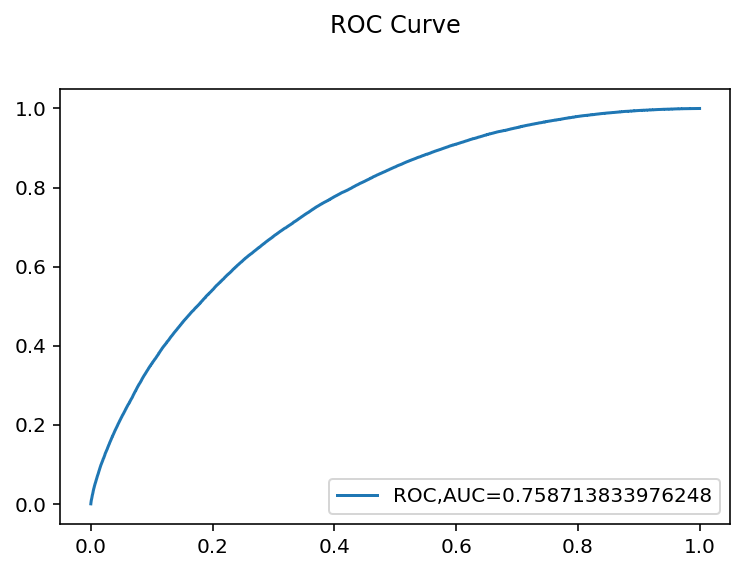

In [121]:
# Get the probability score for observations.
xg1_y_pproba = xgb1.predict_proba(x_val)[::,1]

# Graph Receiver Operating Characteristic(ROC) curve and compute AUC (Area Under the Receiver Operating Characteristic Curve) from prediction scores.
fpr, tpr, _ = metrics.roc_curve(y_val,  xg1_y_pproba)

auc = metrics.roc_auc_score(y_val, xg1_y_pproba)
plt.plot(fpr,tpr,label="ROC,AUC="+str(auc))
plt.title('ROC Curve', y=1.1)
plt.legend(loc=4)
plt.show()

In [122]:
# Create a pd.Series of features importances
importances_xgb1 = pd.Series(xgb1.feature_importances_,
    index = x_tr.columns)

# Sort importances_rf
sorted_importances_xgb1 = importances_xgb1.sort_values(ascending=False)
sorted_importances_xgb1[:30]

sub_grade                           0.236101
issue_year                          0.096480
grade                               0.083244
term_ 60 months                     0.032121
emp_undisc                          0.026319
verification_status_Not Verified    0.019379
acc_open_past_24mths                0.018346
home_ownership_MORTGAGE             0.017371
home_ownership_RENT                 0.014985
issue_month                         0.014973
driver_title                        0.012927
term_ 36 months                     0.011139
disbursement_method_Cash            0.009775
owner_title                         0.009664
sec_app_fico_range_low_verypoor     0.008764
inq_last_6mths                      0.008459
fico_range_low                      0.006741
sec_app_fico_range_high_verypoor    0.006618
purpose_small_business              0.006567
zip_code                            0.006491
int_rate                            0.006319
disbursement_method_DirectPay       0.006272
pub_record

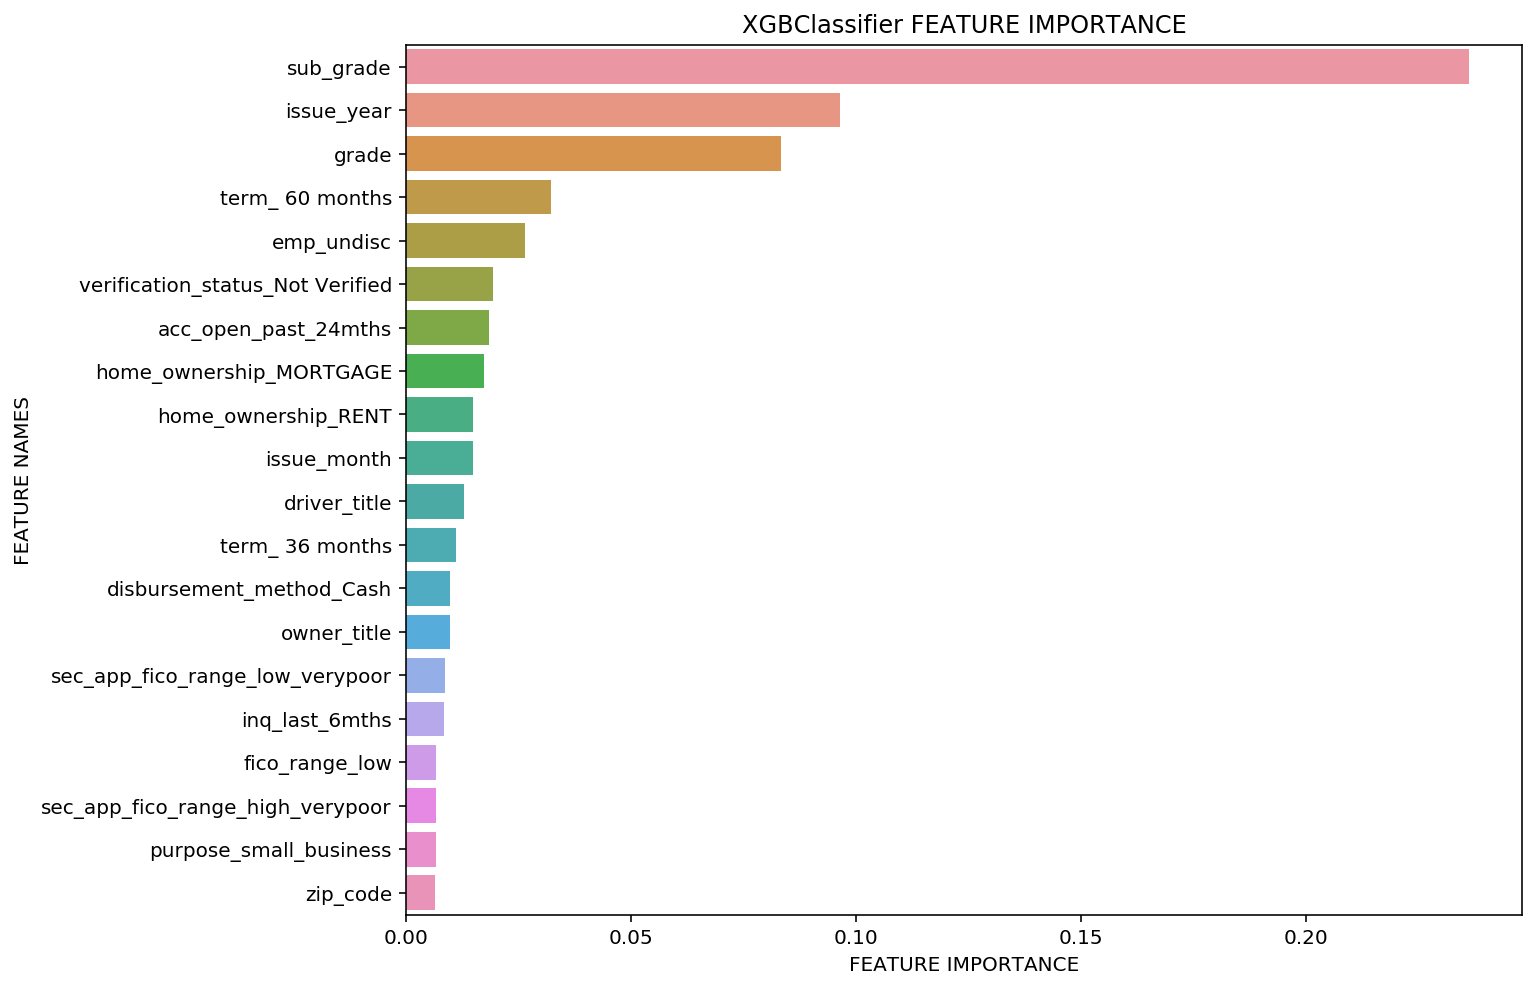

In [123]:
plot_feature_importance(xgb1, x_tr)

#### Tune parameters for xgboost model

In [ ]:
# x_val = pd.DataFrame(x_val, columns=all_cols)
# x_res = pd.DataFrame(x_res, columns=all_cols)

In [149]:
# Parameters to tune
params_tune = {'max_depth':[3,4,6],
               'gamma': [0.5, 1, 1.5],
              'min_child_weight':[2,4,6]}

In [154]:
# initial the base models   
model_estimator = xgb.XGBClassifier(learning_rate =0.01, 
                                    n_estimators=500,                               
                                    objective= 'binary:logistic', 
                                    nthread=4,
                                    scale_pos_weight=1,
                                    seed=27)

# Build RandomSearch 
clf = RandomizedSearchCV(model_estimator, 
                                   param_distributions=params_tune,
                                   scoring="roc_auc",
                                   n_jobs=4, 
                                   cv=3, 
                                   verbose=3, 
                                   random_state=42)

# Fit the RandomSearch Model
clf.fit(x_res, y_res)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 2156.4min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(learning_rate=0.01, n_estimators=500,
                                           nthread=4, seed=27),
                   n_jobs=4,
                   param_distributions={'gamma': [0.5, 1, 1.5],
                                        'max_depth': [3, 4, 6],
                                        'min_child_weight': [2, 4, 6]},
                   random_state=42, scoring='roc_auc', verbose=3)

In [156]:
print('\n All results:')
print(clf.cv_results_)
print('\n Best estimator:')
print(clf.best_estimator_)

print('\n Best hyperparameters:')
print(clf.best_params_)

results = pd.DataFrame(clf.cv_results_)
results.to_csv('xgb-random-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([14312.87179422, 19079.63971678, 17821.22939134, 14804.81279874,
       11250.39051247, 10071.50577831, 14716.74931264, 30268.77490838,
       25987.51880304, 11151.35793376]), 'std_fit_time': array([   33.69642287,  6841.45349143,  5585.22915136,   116.6045309 ,
         307.98806855,  1042.09271399,   163.36161245, 11685.23941939,
       11875.39033929,   394.74198152]), 'mean_score_time': array([40.38176298, 30.26184638, 33.6386447 , 48.7240169 , 37.11146959,
       34.51101065, 54.46603266, 40.81654398, 36.90241861, 29.92591794]), 'std_score_time': array([1.98499669, 2.49549838, 1.86781006, 6.96607899, 2.28287084,
       0.80109957, 7.50816045, 1.10096654, 5.86908341, 5.0148735 ]), 'param_min_child_weight': masked_array(data=[6, 4, 2, 2, 2, 6, 4, 6, 2, 2],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array

In [155]:
best_estimator = clf.best_estimator_

best_estimator

# Save model
pickle.dump(clf.best_estimator_, open("xgb_rdm_best_model.pickle", "wb"))

In [157]:
best_estimator

XGBClassifier(gamma=1.5, learning_rate=0.01, max_depth=6, min_child_weight=2,
              n_estimators=500, nthread=4, seed=27)

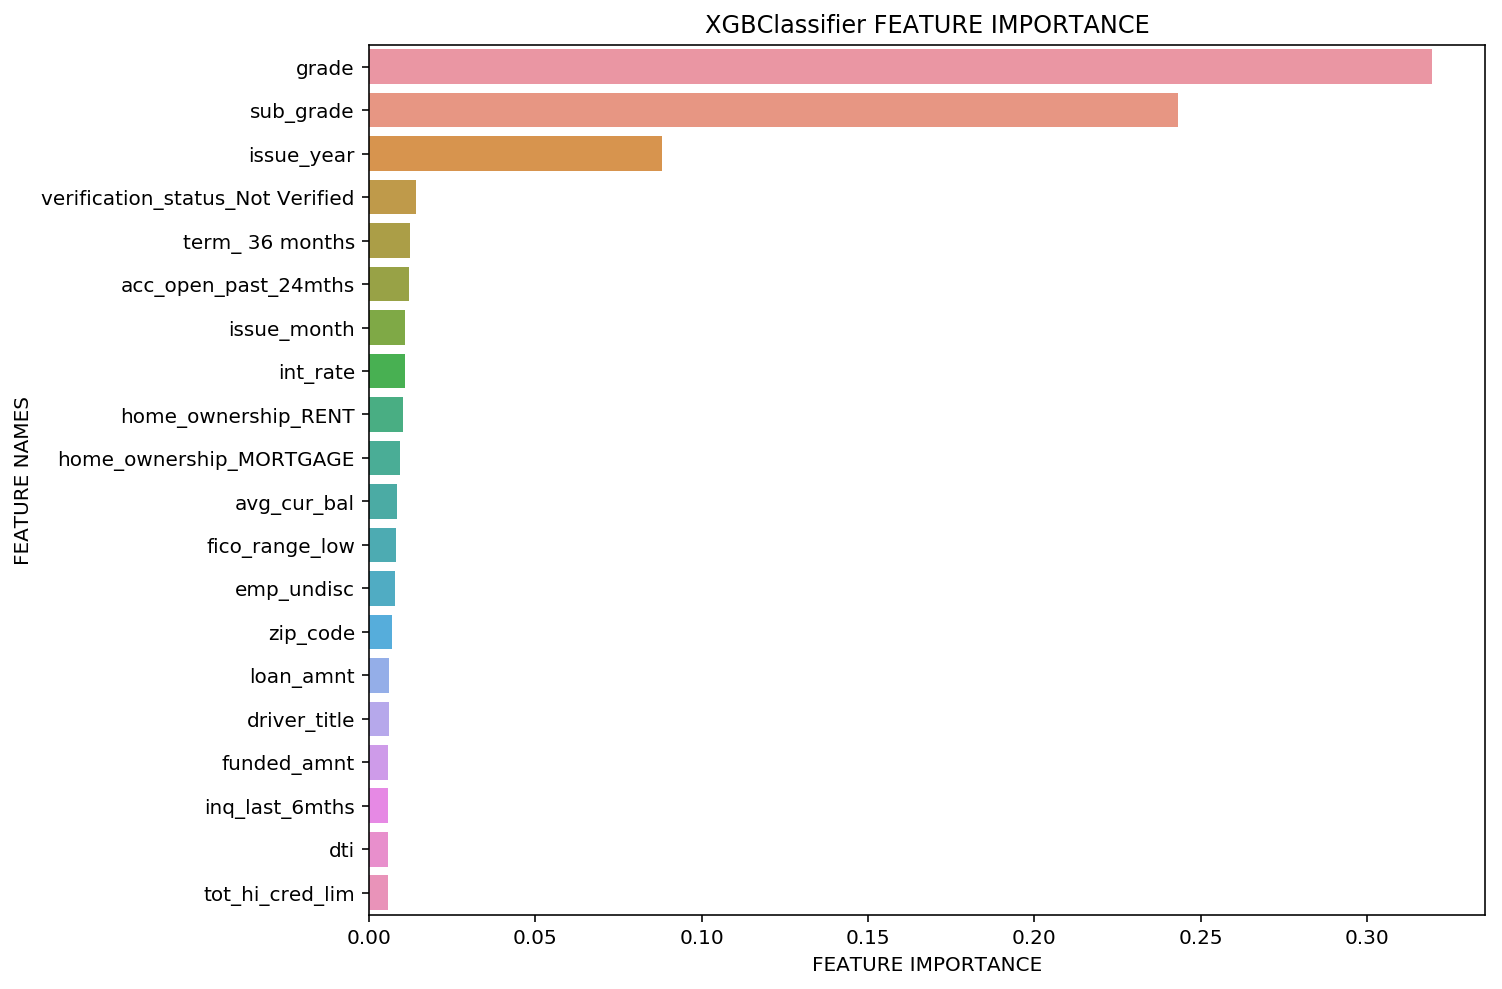

In [172]:
plot_feature_importance(best_estimator, x_tr)

I used XGBClassifier an sklearn wrapper for XGBoost. This allows us to use sklearn’s Grid Search with parallel processing in the same way we did for GBM. We can also use the xgboost package to run the model as follows.

### Run model on test dataset

In [165]:
# Perform Prediction on the test set
ytest_pred = best_estimator.predict(sca_xtest)

In [166]:
xgb_2_matrix = metrics.confusion_matrix(ytest, ytest_pred)
print(xgb_2_matrix)

[[344335  47077]
 [ 37451  23271]]


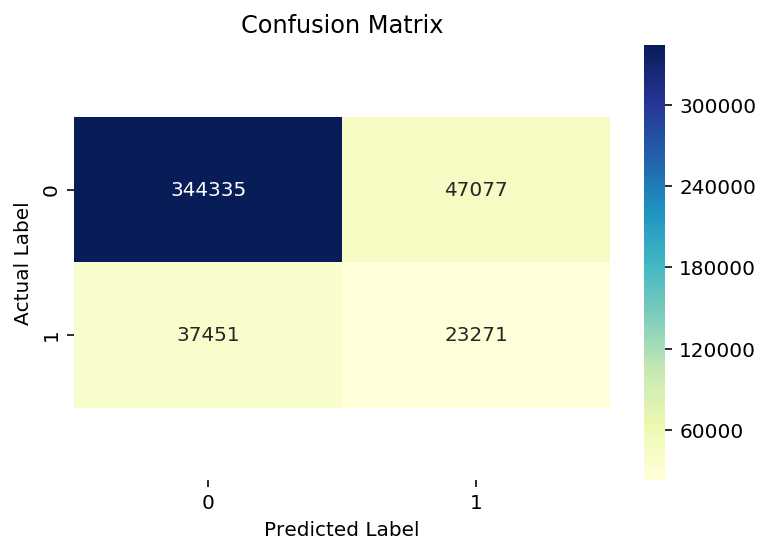

In [169]:
%matplotlib inline

sns.heatmap(xgb_2_matrix,annot=True,cmap="YlGnBu" ,fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

class_names=[0,1] # name  of classes
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs,class_names)
ylocs, ylabels = plt.xticks()
plt.yticks(ylocs,class_names)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()


In [170]:
# Calculate the classification report.

print(classification_report(ytest, ytest_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89    391412
           1       0.33      0.38      0.36     60722

    accuracy                           0.81    452134
   macro avg       0.62      0.63      0.62    452134
weighted avg       0.83      0.81      0.82    452134



In [174]:
def true_negative_rate(tn, fp):
    """
    Args:
        tn: True Negatives (count)
        fp: False Positives (count)

    Returns: true_negative_rate
    """
    return round(tn / (tn + fp), 2)

def false_positive_rate(fp, tn):
    """
    Args:
        fp: False Positives (count)
        tn: True Negatives (count)

    Returns: false_positive_rate
    """
    return round(fp / (fp + tn), 2)

def false_negative_rate(fn, tp):
    """
    Args:
        fn: False Negatives (count)
        tp: True Positives (count)

    Returns: false_negative_rate
    """
    return round(fn / (fn + tp), 2)


In [175]:
tn, fp, fn, tp = metrics.confusion_matrix(ytest, ytest_pred).ravel()

In [178]:
#Sensitivity = TruePositive / (TruePositive + FalseNegative)
Sensitivity = tp/(tp + fn)
print("specificity(Test set):",round(Sensitivity,4))

specificity(Test set): 0.3832


In [181]:
# Sensitivity is also the recall 
recall = Sensitivity

In [179]:
# Specificity = TrueNegative / (FalsePositive + TrueNegative)
Specificity = tn/(fp+tn)
print("Specificity(Test set)",round(Specificity,4))

Specificity(Test set) 0.8797


In [180]:
# precision 
precision = tp/(tp+fp)
print("precision(Test set)", round(precision,4  ))

precision(Test set) 0.3308


In [184]:
f_measure = (2 * precision * recall) / (precision + recall)
print("f_measure(Test set)", round(f_measure,4  ))

f_measure(Test set) 0.3551


In [185]:
print("Accuracy (Test set):", round(metrics.accuracy_score(ytest, ytest_pred),4))
print("Precision (Test set):",round(metrics.precision_score(ytest, ytest_pred),4))
print("Recall/TPR(Test set):",round(metrics.recall_score(ytest, ytest_pred),4))

Accuracy (Test set): 0.813
Precision (Test set): 0.3308
Recall/TPR(Test set): 0.3832


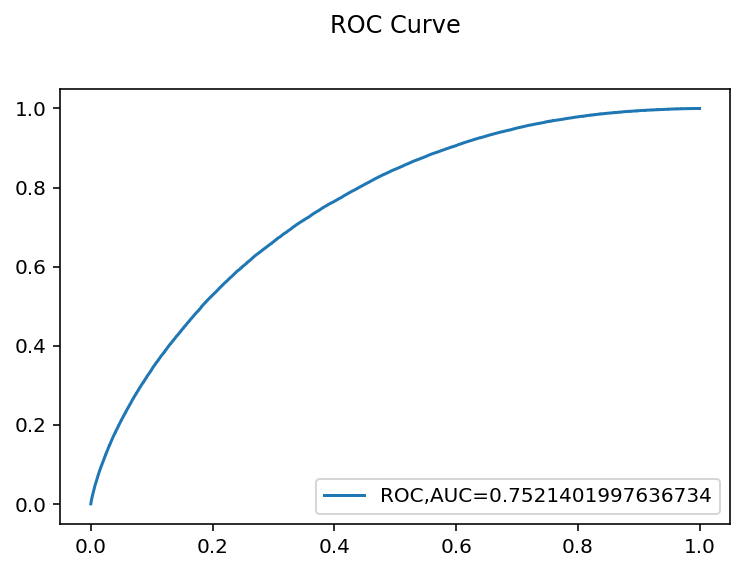

In [168]:
# Get the probability score for observations.
y_pred_proba = best_estimator.predict_proba(sca_xtest)[::,1]

# Graph Receiver Operating Characteristic(ROC) curve and compute AUC (Area Under the Receiver Operating Characteristic Curve) from prediction scores.
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_proba)

auc = metrics.roc_auc_score(ytest, y_pred_proba)
plt.plot(fpr,tpr,label="ROC,AUC="+str(auc))
plt.title('ROC Curve', y=1.1)
plt.legend(loc=4)
plt.show()

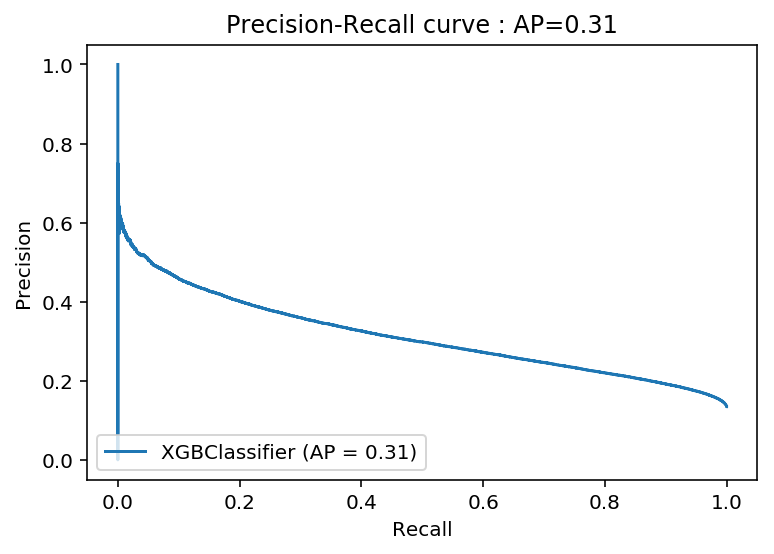

In [186]:
average_precision = metrics.average_precision_score(ytest,  y_pred_proba)
disp_prec = metrics.plot_precision_recall_curve(best_estimator, sca_xtest, ytest)
disp_prec.ax_.set_title('Precision-Recall curve' + 
                        ' : AP={0:0.2f}'.format(average_precision))
plt.show()

#### Evaluate Model Performance on Test Set

Finally, we use the best estimator from the randomized search of xgboost model to classify loan default(yes or no) on the test set. The overall accuracy score is 0.81%, which means that model can distinguish between good loans and default loans 81% of the time. This is not bad.

However, there are more to consider since the lending club loans is an imbalanced dataset - the minority group(bad loans) accounts for only 13% of the population. There are two groups of metrics that may be useful in evaluating imbalanced classification because they allow us to focus on one class at a time, that is to assess how well the model predict each class separately. The are sensitivity-specificity and precision-recall([good expalanation here](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)).

- sensitivity-specificity
    * Sensitivity(also recall, true positive rate) summarizes how well the positive class was predicted (measures the proportion of positives that are correctly identifie). On the other hand, specificity measures the proportion of negatives that are correctly identified. For imbalanced classification (most of the time, the positive class is the minority class), we are more concerned Sensitivity than specificity.

    * The sensitity is 38.3% while the specificity is 87.9%. What this is telling us is that the model is really good at identifying good loans but not so much for "bad" loans. The model is able to identify a "good" loans 88% of the time on average, while it has 38% chances to correctly identify one "default" loan (like 2 out of 3 default loans will be missed).

- precision-recall

    * Precision measures the fraction of examples assigned the positive class that actually belong to the positive class. Recall is the same as Sensitivity, summarizing proportion of positives that are correctly identified. The F-Measure is a popular metric for imbalanced classification as it combines both precision and recall (harmonic mean of Precision and Recall). What F-Measures tells us about is how well the perdiction of the positive class since F-Measures is calculated with two metrics, Precision and Recall that are mainly focus on the positive class. The F-Measure on the test set is 0.3551, which indicates the model is not really good at labeling positive class.
    

Another useful tool for evaluating imbalanced classification is ROC(Receiver Operating Characteristic) curve and ROC AUC(area under ROC curve) score. A no skill model will have a ROC AUC score of 0.5, whereas a perfect model will have a ROC AUC score of 1.0. The ROC AUC score of xgboost model using the test dataset is 0.75, which is means it is a skilled model.



#### Areas of improvements

To improve this project, I would like to test xgboost models with the features selected by Lasso regression and random forest. Also, I would like to perform hyperparameters tuning for Xgboost model.